# Loading packages

In [1]:
!pip install medmnist
!pip install evaluate
!pip install wandb
!pip install fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=5

In [16]:
from transformers import ViTImageProcessor, ViTForImageClassification, ViTConfig, ViTModel
from PIL import Image
import requests
from medmnist import OCTMNIST, PathMNIST, DermaMNIST, RetinaMNIST, BloodMNIST
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from medmnist import INFO, Evaluator
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import numpy as np
from evaluate import load
from transformers import TrainingArguments, Trainer
import os
from fastai.vision.augment import Resize, ResizeMethod
from matplotlib.pyplot import imshow

# Loading MNIST datasets

In [3]:
path_dataset = PathMNIST(split="train", download=True)
path_dataset

100%|██████████| 206M/206M [00:11<00:00, 18.7MB/s]


Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K

In [4]:
derma_dataset = DermaMNIST(split="train", download=True)
derma_dataset

100%|██████████| 19.7M/19.7M [00:01<00:00, 10.7MB/s]


Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints: 7007
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0

In [5]:
blood_dataset = BloodMNIST(split="train", download=True)
blood_dataset

100%|██████████| 35.5M/35.5M [00:02<00:00, 14.1MB/s]


Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC B

In [6]:
retina_dataset = RetinaMNIST(split="train", download=True)
retina_dataset

100%|██████████| 3.29M/3.29M [00:01<00:00, 3.01MB/s]


Dataset RetinaMNIST of size 28 (retinamnist)
    Number of datapoints: 1080
    Root location: /root/.medmnist
    Split: train
    Task: ordinal-regression
    Number of channels: 3
    Meaning of labels: {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'}
    Number of samples: {'train': 1080, 'val': 120, 'test': 400}
    Description: The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.
    License: CC BY 4.0

# Updating labels of MNIST datasets

prevent concat dataset to have labels with same index but different values

In [7]:
class UpdateLabelsMNSIT(Dataset):
  def __init__(self, dataset, labels_shift):
    self.dataset = dataset
    self.labels_shift = labels_shift

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    image, label = self.dataset[idx]
    label = label + self.labels_shift
    return image, label

updated_derma_dataset = UpdateLabelsMNSIT(derma_dataset, 9)
updated_blood_dataset = UpdateLabelsMNSIT(blood_dataset, 16)
updated_retina_dataset = UpdateLabelsMNSIT(retina_dataset, 24)

In [8]:
concat_datasets = torch.utils.data.ConcatDataset([path_dataset, updated_derma_dataset, updated_blood_dataset, updated_retina_dataset])

In [9]:
concat_datasets[89995] # Path MNIST

(<PIL.Image.Image image mode=RGB size=28x28>, array([2]))

In [10]:
concat_datasets[89996] # Derma MNIST

(<PIL.Image.Image image mode=RGB size=28x28>, array([9]))

In [11]:
concat_datasets[97004] # Blood MNIST

(<PIL.Image.Image image mode=RGB size=28x28>, array([19]))

In [12]:
concat_datasets[108967] # Retina MNIST

(<PIL.Image.Image image mode=RGB size=28x28>, array([24]))

# Preparing Concat Datasets for Fine-tuning

In [13]:
class ConcatMNIST(Dataset):
  def __init__(self, concat_datasets):
    self.concat_datasets = concat_datasets

  def __len__(self):
    return len(self.concat_datasets)

  def __getitem__(self, idx):
    image, label = self.concat_datasets[idx]
    item = {'pixel_values' : image, 'labels' : label}
    return item

In [14]:
train_mnist_dataset = ConcatMNIST(concat_datasets)

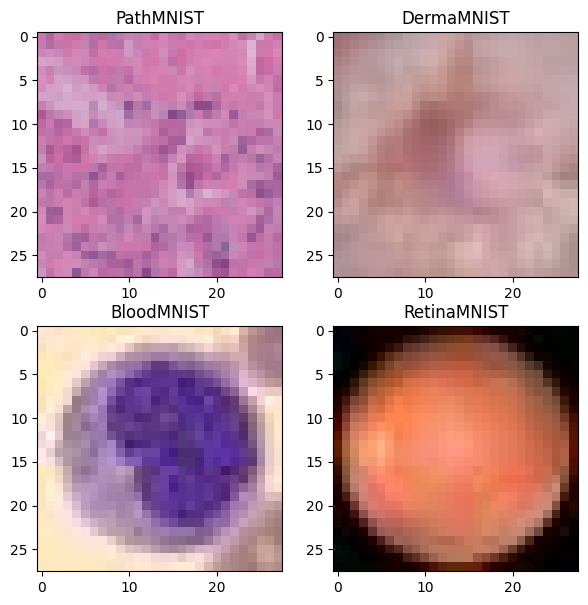

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7),)
axs[0, 0].set_title('PathMNIST')
axs[0, 0].imshow(train_mnist_dataset[89995]['pixel_values'])
axs[0, 1].set_title('DermaMNIST')
axs[0, 1].imshow(train_mnist_dataset[89996]['pixel_values'])
axs[1, 0].set_title('BloodMNIST')
axs[1, 0].imshow(train_mnist_dataset[97004]['pixel_values'])
axs[1, 1].set_title('RetinaMNIST')
axs[1, 1].imshow(train_mnist_dataset[108967]['pixel_values'])

In [25]:
train_mnist_dataset[108967]['labels']

array([24])